In [54]:
from math import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import random
import functools

In [55]:
sns.set()

In [56]:
#exporto columnas
M = np.genfromtxt('datos2.dat', delimiter=',', usecols=0) #magnitud
f = np.genfromtxt('datos2.dat', delimiter=',', usecols=1) #frecuencia (es el fi)

In [57]:
#errores
e_in = np.genfromtxt('errores_inferiores.dat', delimiter=',', usecols=1) #puntos inferiores
e_su = np.genfromtxt('errores_superiores.dat', delimiter=',', usecols=1) #puntos superiores

In [58]:
#largo de las barras de error
d_in = f - e_in  #inferior
d_su = e_su - f  #superior

In [59]:
#sigmas de las gaussianas
sigma= (e_su - e_in)/2

In [60]:
#sigmas
sig_fi0= 0.00002 
sig_M0=0.002
sig_a=0.002

proposal=functools.partial(np.random.multivariate_normal, cov = [[sig_fi0, 0 , 0], [0, sig_M0, 0], [0,0,sig_a]])

In [61]:
def likelihood(M, f, fi0, M0, a, sigma):
    f_model = model(M,fi0,M0,a)
    
    #gaussiana centrada en el f(o fi) del modelo y sigma definido arriba:
    prob= st.norm(f_model, sigma).pdf(f) #evaluo en f, es VECTORIAL
    
    #las multiplico a todas:
    like=prob.prod()
    return like

In [62]:
#modelo
def model(M,fi0,M0,a):
    lista=[]
    for i in range(len(M)):
        y=0.4 * log(10) * fi0 * (10**(-0.4*(M[i]-M0)*(a+1))) * exp(-10**(-0.4*(M[i]-M0))) #schechter
        lista.append(y)
    return lista

In [63]:
#prior plano
def prior(fi0,M0,a):
    p=st.uniform(loc=[0.0004, -21.9, -1.9], scale=[0.0396, 2.8, 1.899])  #defino el cubo donde es constante
    r=p.pdf([fi0,M0,a]) #evaluo en el punto
    i=r.prod()   #los multiplico
    return i

In [64]:
def posterior(M, f, fi0, M0, a, sigma=sigma):    
    pos= likelihood(M,f,fi0,M0,a,sigma) * prior(fi0,M0,a)
    return(pos)

Se quiere visualizar las propiedades de convergencia de varias cadenas, para ello se realizarán 5 cadenas y luego se grafican los parámetros en función de los pasos.

In [65]:
cadenas_fi0=[] #aca se van a guardar as nuevas cadenas
cadenas_M0=[]
cadenas_a=[]

for j in range(5):
    post2=0
    while post2 < (1.e-8): #es como un for
        fi0_inic2=random.uniform(0.0004, 0.04)
        M0_inic2=random.uniform(-21.9, -19.1)
        a_inic2=random.uniform(-1.9, -0.001)
        post2= posterior(M, f, fi0_inic2, M0_inic2, a_inic2) #evaluo en los parametros iniciales
    
    cadena_fi02= [fi0_inic2]
    cadena_M02= [M0_inic2]
    cadena_a2= [a_inic2]
    #posteriores=[post]
    n_pasos2=5000
    
    for i in range(n_pasos2):
        fi0_new2, M0_new2, a_new2= proposal([fi0_inic2, M0_inic2, a_inic2])
        post_new2= posterior(M, f, fi0_new2, M0_new2, a_new2) 
        
        prob_aceptacion2= min(1, post_new2/post2)
        u2=random.random()
        if u2 < prob_aceptacion2 : #condcion para aceptar el punto
            fi0_inic2= fi0_new2
            M0_inic2= M0_new2
            a_inic2= a_new2
            post2=post_new2
        cadena_fi02.append(fi0_inic2)
        cadena_M02.append(M0_inic2)
        cadena_a2.append(a_inic2)
        #posteriores.append(post)
    
    cadenas_fi0.append(cadena_fi02)
    cadenas_M0.append(cadena_M02)
    cadenas_a.append(cadena_a2)

Text(0, 0.5, 'alfa')

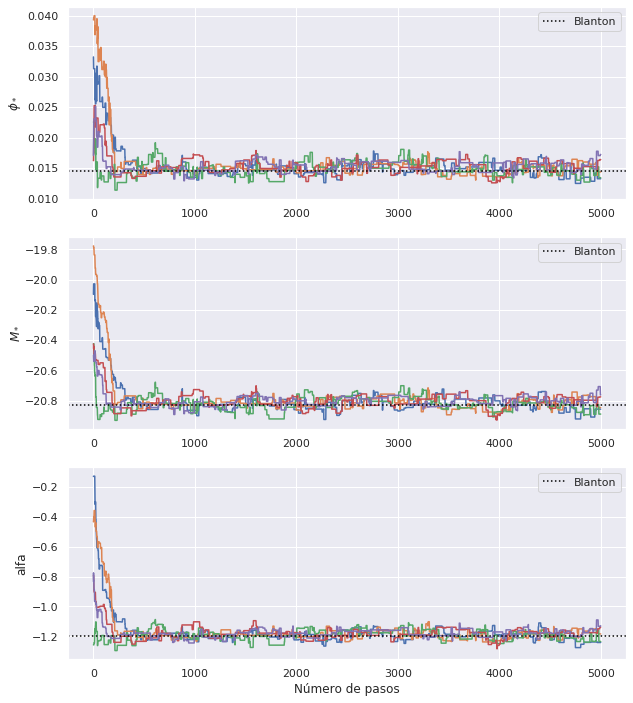

In [66]:
#graficos
plt.figure(figsize=(10,12))

plt.subplot(3,1,1)
plt.plot(cadenas_fi0[0])
plt.plot(cadenas_fi0[1])
plt.plot(cadenas_fi0[2])
plt.plot(cadenas_fi0[3])
plt.plot(cadenas_fi0[4])
plt.axhline(0.0146, color='black', label='Blanton', ls="dotted") #valor esperado
plt.legend(loc='upper right')
plt.ylabel('$\phi_*$')

plt.subplot(3,1,2)
plt.plot(cadenas_M0[0])
plt.plot(cadenas_M0[1])
plt.plot(cadenas_M0[2])
plt.plot(cadenas_M0[3])
plt.plot(cadenas_M0[4])
plt.axhline(-20.83, color='black', label='Blanton', ls="dotted")
plt.legend(loc='upper right')
plt.ylabel('$M_*$')

plt.subplot(3,1,3)
plt.plot(cadenas_a[0])
plt.plot(cadenas_a[1])
plt.plot(cadenas_a[2])
plt.plot(cadenas_a[3])
plt.plot(cadenas_a[4])
plt.axhline(-1.2, color='black', label='Blanton', ls="dotted")
plt.legend(loc='upper right')
plt.xlabel('Número de pasos')
plt.ylabel('alfa')

Al visualizar las cadenas se nota que todas ellas convergen alrededor del mismo valor (los esperados). Se vuelve a notar el "quemado" aproximadamente a los 500 pasos, pero para el calculo de los promedios se considera a partir del paso 1000.

In [67]:
#promedios considerando a partir de 1000 (quemado)
promedios_fi0=[] #listas con los promedios de cada cadena
promedios_M0=[]
promedios_a=[]

for i in range(5): #numero de cadenas
    quema_fi0=cadenas_fi0[i][1000:]
    quema_M0=cadenas_M0[i][1000:]
    quema_a=cadenas_a[i][1000:]
    
    prom_fi0=np.mean(quema_fi0)
    prom_M0=np.mean(quema_M0)
    prom_a=np.mean(quema_a)
    
    promedios_fi0.append(prom_fi0)
    promedios_M0.append(prom_M0)
    promedios_a.append(prom_a)

In [68]:
fi0_encontrado=np.mean(promedios_fi0)
print('El valor encontrado para el parámetro fi0 es:', fi0_encontrado)

M0_encontrado=np.mean(promedios_M0)
print('El valor encontrado para el parámetro M0 es:', M0_encontrado)

a_encontrado=np.mean(promedios_a)
print('El valor encontrado para el parámetro a es:', a_encontrado)

El valor encontrado para el parámetro fi0 es: 0.015024818673542903
El valor encontrado para el parámetro M0 es: -20.813148687491992
El valor encontrado para el parámetro a es: -1.186733728773801


NameError: name 'sx' is not defined

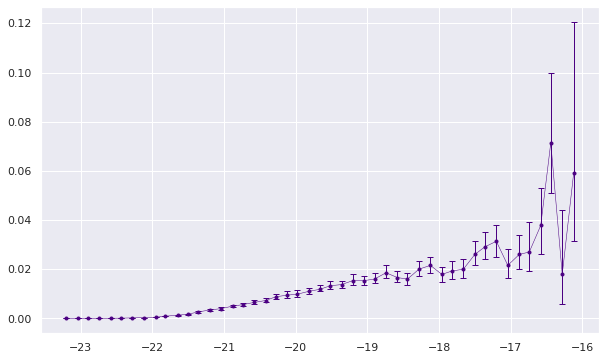

In [69]:
plt.figure(figsize=(10,6))
#datos con errores
plt.errorbar(M, f, yerr= (d_in, d_su), marker='o', markersize=3, color='indigo', ecolor='indigo', elinewidth=1, linewidth=0.5, label='Datos')
plt.plot(M,e_in, '_', color='indigo')
plt.plot(M,e_su, '_', color='indigo')
#mis parámetros:
plt.plot(sx,model(sx, fi0=0.01492, M0=-20.82, a=-1.19), color='red', label='Parámetros obtenidos')

plt.yscale('log')
plt.xlabel('$M_r$')
plt.ylabel('$\phi(M_r)$')
plt.legend(loc='lower right')
plt.show()



Al observar el grafico se ve que los valores obtenidos ajustan bien a los puntos, cayendo dentro de las barras de error de la mayoría de ellos.

Por otro lado, al comparar los valores con los que obtuvieron Blanton et al. 2001, los encontrados con las cadenas caen dentro del error estimado por ellos, por lo que el método fue efectivo para encontrar los parámetros que ajustan a la función.
Conclusiones

Los métodos Bayesianos, frecuentemente implementados usando las Cadenas de Markov Monte Carlo (MCMC), proveen una manera poderosa de estimar los parámetros de un modelo realizando un muestreo aleatorio del espacio de parámetros.

En este caso se logró ajustar la función de Schechter a la función de luminosidad de galaxias obtenida por Blanton et al. 2001 por medio de la implementación del algoritmo Metrópolis-Hastings para llevar a cabo realizaciones de MCMC.

Los parámetros encontrados son:
$$\phi_* = 0.01492, M_*=-20.82, \alpha=-1.19$$

los cualesajustan bien a los datos y pertenecen al intervalo de parámetros encontrados por Blanton et al. 2001.
